In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd

In [36]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [38]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [40]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [43]:
#Take a peek at the Station table
station = session.query(Station).first()
station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25f148efac8>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [44]:
#Take a peek at the Measurement table 
measure = session.query(Measurement).first()
measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25f148efef0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Find last data point date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [46]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23 00:00:00


In [47]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(prcp.statement, prcp.session.bind)
new_df = df.set_index(['date'])

# Sort the dataframe by date
sorted_df = new_df.sort_index()

In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
print(sorted_df['prcp'].max())

6.7


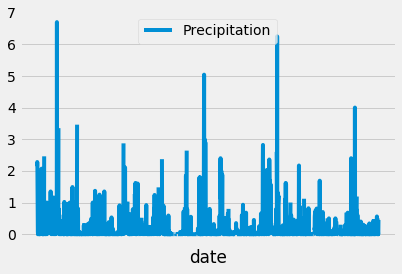

In [50]:
# Plot the results using the DataFrame
#sorted_df.plot(kind="bar", figsize=(10, 4))
sorted_df.plot()
plt.xticks([], [])
plt.legend(["Precipitation"])

In [51]:
# Design a query to show how many stations are available in this dataset?
print(f"There are {session.query(func.count(Station.station)).all()[0][0]} sessions in this dataset.")

There are 9 sessions in this dataset.


In [52]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by((func.count(Measurement.id)).desc()).all()  


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

print(f"The lowest temperature recorded was {session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]}.")
print(f"The highest temperature recorded was {session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]}.")
print(f"The average temperature of the most active station was {session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]}.")


The lowest temperature recorded was 54.0.
The highest temperature recorded was 85.0.
The average temperature of the most active station was 71.66378066378067.


In [54]:
# Choose the station with the highest number of temperature observations.

print(f"The station with the highest number of temperature observations\
 was {session.query(Measurement.station, Measurement.tobs).order_by(Measurement.tobs.desc()).first()[0]}.")

The station with the highest number of temperature observations was USC00519397.


Text(0, 0.5, 'Frequency')

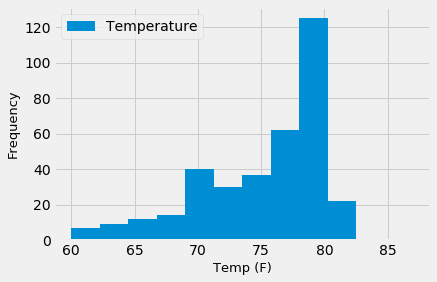

In [55]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago).filter(Measurement.station == "USC00519397")

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.read_sql(temp.statement, temp.session.bind)
temp_df.plot(kind="hist", bins=12)
plt.legend(["Temperature"])
plt.xlabel("Temp (F)", size=13)
plt.ylabel("Frequency", size=13)

In [56]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Text(0, 0.5, 'Temp (F)')

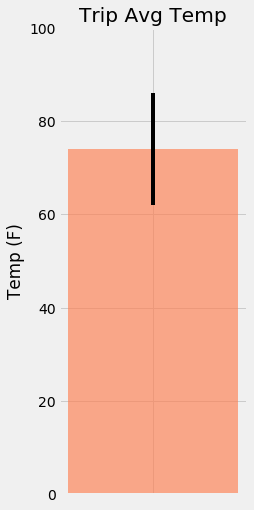

In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
x = calc_temps("2017-03-20", "2017-03-29")

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = x[0][1]
z = (x[0][2] - x[0][0])
x_axis = ""
plt.figure(figsize=(3, 8))
plt.bar(x_axis, y, color="coral", alpha=0.65, align="center", width=0.2, yerr = z)
plt.ylim(0, 100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")


In [58]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.

# Sort this in descending order by precipitation amount 
#and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= "2017-03-20").\
    filter(Measurement.date <= "2017-03-29").\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.43),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.1800000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.76),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.18),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]